Healthy
Positive
Healthy
Negative
Anxious
Positive
Anxious
Negative


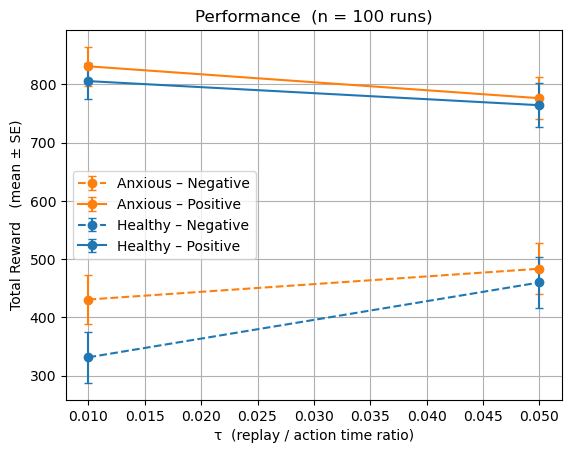

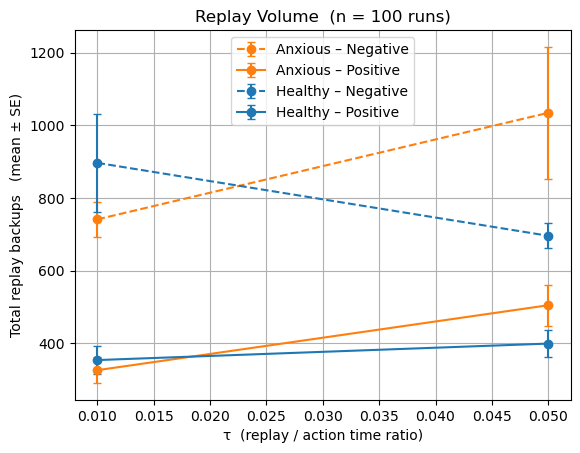

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product

# ------------------------------------------------------------
# 1.  Environment
# ------------------------------------------------------------
GRID_SIZE   = 3
ACTIONS     = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}  # U, R, D, L
N_ACTIONS   = 4

REWARD_SCALE = 10
SMALL_REWARD_SCALE = 10  # NEW: smaller rewards for other locations
SMALL_REWARD_PROB = 0.3  # NEW: probability of getting small reward
PROBABILITY_SCALE=0.3
INIT_EXPERIENCE_EPISODE=0
TOTAL_EXPERIENCES_ONLINE=100
TOTAL_EPISODES_ONLINE=2
CHANGE_REWARD_INTERVAL=TOTAL_EPISODES_ONLINE/20.0
TOTAL_EXPERIENCES_OFFLINE_TRAINING=500
LEARNING_RATE=0.1

GAMMA_ANX=0.50
GAMMA_HEALTHY=0.50
INV_TEMP=3
# ----- helpers ------------------------------------------------

def clip(z: int) -> int:
    """Keep coordinate inside the grid."""
    return max(0, min(z, GRID_SIZE - 1))


def step(state, a, t, rwd, pun):
    """
    Take action a from state, return (next_state, reward).
    Now includes small random rewards at non-key locations.
    """
    dx, dy = ACTIONS[a]
    nxt = (clip(state[0] + dx), clip(state[1] + dy))

    current_outcome = 1

    # Check if we hit the main reward or punishment location
    if nxt == rwd:
        r = REWARD_SCALE * current_outcome
    elif nxt == pun:
        r = -REWARD_SCALE * current_outcome
    else:
        # NEW: Random small rewards at other locations
        if random.random() < SMALL_REWARD_PROB:
            r = random.choice([-SMALL_REWARD_SCALE, SMALL_REWARD_SCALE])
        else:
            r = 0
        
    return nxt, r


def step_explore(state, a):
    """Like `step`, but with zero reward (used for SR pre‑training)."""
    dx, dy = ACTIONS[a]
    nxt    = (clip(state[0] + dx), clip(state[1] + dy))
    return nxt, 0


def softmax(q, beta=5.0):
    q = np.array(q) - np.max(q)
    p = np.exp(beta * q)
    return p / p.sum()

# ---------- random reward & punishment locations -------------
def sample_valence_states(grid_size=GRID_SIZE):
    """Return two distinct (x, y) tuples drawn uniformly at random."""
    all_states = list(product(range(grid_size), repeat=2))
    reward_st, punish_st = random.sample(all_states, k=2)  # no replacement
    return reward_st, punish_st

# ----- state ↔ index maps (for SR) ---------------------------
state2idx = {(x, y): y + GRID_SIZE * x for x in range(GRID_SIZE) for y in range(GRID_SIZE)}
idx2state = {v: k for k, v in state2idx.items()}

# ------------------------------------------------------------
# 2.  Simulation
# ------------------------------------------------------------

def simulate_condition(agent_type: str,
                       first_outcome: str,
                       tau: float,
                       n_episodes: int = TOTAL_EPISODES_ONLINE,
                       n_steps: int = TOTAL_EXPERIENCES_ONLINE,
                       n_steps_explore: int = TOTAL_EXPERIENCES_OFFLINE_TRAINING,
                       alpha: float = LEARNING_RATE,
                       gam_anx: float = GAMMA_ANX,
                       gam_healthy: float = GAMMA_HEALTHY,
                       gamma_learn: float = 0.99,
                       ep_init_rwd: int = INIT_EXPERIENCE_EPISODE,
                       change_rwd: int = CHANGE_REWARD_INTERVAL,
                       beta: float = INV_TEMP,
                       td_min: float = 1e-8,
                       burst_max: int = 200):
    """Run one episode and return (ΔV(s₀), total_replay_backups)."""
    
    # ---------- initialise value and SR ----------------------
    Q  = np.zeros((GRID_SIZE, GRID_SIZE, N_ACTIONS))
    SR = np.zeros((GRID_SIZE ** 2, GRID_SIZE ** 2))+1/9
    
    # FIXED: Initialize reward locations that align with first experience setup
    REWARD_ST   = (0, 0)
    PUNISH_ST   = (2, 2)

    # ---------- counters for dynamic learning‑rates ----------
    update_counts_SR = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    update_counts_RWD = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    # ---------- memory & bookkeeping -------------------------
    memory       = []

    total_replay = 0
    total_reward = 0

    def alpha_SR(st):
        n = update_counts_SR[st]
        return 1.0 if n == 0 else 1.0 / n
    
    def alpha_RWD(st):
        n = update_counts_RWD[st]
        return 1.0 if n == 0 else 1.0 / n
    
    def legal_actions(state):
        """Return a list of actions whose next-state ≠ current state."""
        return [a for a in range(N_ACTIONS) if step(state, a, 1, (0,0), (0,1))[0] != state]

    def pick_action(state, Q, beta=5.0):
        """Soft-max policy over legal actions only."""
        acts = legal_actions(state)
        if not acts:
            acts = list(range(N_ACTIONS))
        q_subset = np.array([Q[state + (a,)] for a in acts])
        p_subset = softmax(q_subset, beta)
        return np.random.choice(acts, p=p_subset)



    # ---------- nested: replay burst -------------------------
    def replay_burst(curr_state,first_experience):
        n_burst = 0
        
    
        V_cost  = np.dot(softmax(Q[curr_state], beta), Q[curr_state])
        
        nonlocal total_replay, gam_anx, gam_healthy
        while n_burst < burst_max:
            
            best_evb_c, best_mem = 0, 0

            for (s_mem, a_mem, r_mem, s2_mem) in memory:
                need   = SR[state2idx[curr_state], state2idx[s_mem]]
                q_old  = Q[s_mem + (a_mem,)]
                td     = r_mem + gamma_learn * np.max(Q[s2_mem]) - q_old
                if abs(td) < td_min:
                    continue

                a_mem_lr = alpha
                q_new    = q_old + a_mem_lr * td

                q_tmp          = Q[s_mem].copy()
                q_tmp[a_mem] = q_new
                new_policy_v=np.dot(softmax(q_tmp, beta), q_tmp)
                old_policy_v=np.dot(softmax(Q[s_mem], beta), q_tmp)
                
                gain           = (np.dot(softmax(q_tmp, beta), q_tmp) -
                                   np.dot(softmax(Q[s_mem], beta), q_tmp))

                if (agent_type == "Anxious" and r_mem < 0):
                    g_now = gam_anx + 0.45
                elif (agent_type == "Anxious" and r_mem >= 0):
                    g_now = gam_anx - 0.45
                else:
                    g_now = gam_healthy

                evb   = need * gain
                evb_c = ((g_now ** tau) * evb) - ((1 - g_now ** tau) * V_cost)
                # if first_experience=='Negative':
                #     print('rwd:{}'.format(r_mem))
                #     print('EVB:{}, OPP_COST:{}, EVB_C:{}, old_policy:{},new_policy:{} \n'.format(evb,V_cost,evb_c,old_policy_v,new_policy_v))
                
                
                if evb_c > best_evb_c:
                    best_evb_c, best_mem = evb_c, (s_mem, a_mem, q_new, r_mem)
            
            eps = 0.000001
            if best_evb_c <= 0 + eps:
                break
            s_b, a_b, q_new_b, r_b = best_mem
            Q[s_b + (a_b,)] = q_new_b
            
            total_replay += 1
            n_burst += 1

    # ---------- helper: perform one exploratory SR step ------
    def sr_train_step(s_t, a_t):
        nonlocal memory
        update_counts_SR[s_t] += 1
        a_lr = alpha_SR(s_t)

        s_next, r_t = step_explore(s_t, a_t)
        if s_next == s_t:
            a_t = pick_action(s_t, Q, beta)
            s_next, r_t = step_explore(s_t, a_t)

        # memory.append((s_t, a_t, r_t, s_next))
        # memory = memory[:15]

        td = r_t + gamma_learn * np.max(Q[s_next]) - Q[s_t + (a_t,)]
        Q[s_t + (a_t,)] += a_lr * td

        idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
        SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
        SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])

        a_next = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
        return s_next, a_next

    # --------------------------------------------------------
    # 2a.  SR pre‑training (free exploration)
    # --------------------------------------------------------
    s_t = random.choice(list(state2idx))
    a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))

    for _ in range(n_steps_explore):
        s_t, a_t = sr_train_step(s_t, a_t)

    # --------------------------------------------------------
    # 2b.  Main episode with rewards & replay
    # --------------------------------------------------------
    first_experience_given = False  # NEW: Track if first experience happened

    for e in range(n_episodes):
        # FIXED: Handle first experience BEFORE randomizing
        if e == ep_init_rwd and not first_experience_given:
            if first_outcome == "Positive":
                # Start adjacent to reward, moving toward it
                s_t, a_t = (0, 1), 3  # at (0,1), action 3 (left) → (0,0) = REWARD_ST
            else:  # Negative
                # Start adjacent to punishment, moving toward it  
                s_t, a_t = (1, 2), 2  # at (1,2), action 2 (down) → (2,2) = PUNISH_ST
            
            first_experience_given = True
        else:
            # Normal episode: randomize start
            s_t = random.choice(list(state2idx))
            a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_t], beta))

        # Change reward locations periodically (but NOT on the first experience episode)
        if (e + 1) % change_rwd == 0 and e != ep_init_rwd:
            REWARD_ST, PUNISH_ST = sample_valence_states()

        for t in range(n_steps):
            
            update_counts_RWD[s_t] += 1
            a_lr = alpha
            s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST)

            if s_next == s_t:
                a_t = pick_action(s_t, Q, beta)
                s_next, r_t = step(s_t, a_t, t, REWARD_ST, PUNISH_ST)

            memory.append((s_t, a_t, r_t, s_next))
            memory = memory[:15]

            td = r_t + (gamma_learn * np.max(Q[s_next])) - Q[s_t + (a_t,)]
            
            Q[s_t + (a_t,)] += a_lr * td
            
            
            idx_s, idx_snxt = state2idx[s_t], state2idx[s_next]
            SR[idx_s, idx_s] += a_lr * (1 - SR[idx_s, idx_s])
            SR[idx_s, :]     += a_lr * (gamma_learn * SR[idx_snxt, :] - SR[idx_s, :])

            replay_burst(s_t,first_outcome)

            # if r_t != 0:
            #     
            #     a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
                
            #     all_states = [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)]
            #     valid_states = [s for s in all_states if s != REWARD_ST and s != PUNISH_ST]
            #     s_t = random.choice(valid_states)
            # else:
            total_reward += r_t
        
            a_t = np.random.choice(N_ACTIONS, p=softmax(Q[s_next], beta))
            s_t = s_next

    return total_reward, total_replay


# ------------------------------------------------------------
# 3.  Parameter sweep – MANY RUNS
# ------------------------------------------------------------
n_runs   = 100
tau_vals = [0.01, 0.05]
scenarios = [
    ("Healthy", "Positive"), ("Healthy", "Negative"),
    ("Anxious", "Positive"), ("Anxious", "Negative")
]

records = []
for agent, first_exp in scenarios:
    print(agent)
    print(first_exp)
    for tau in tau_vals:
        for _ in range(n_runs):
            dV, nrep = simulate_condition(agent, first_exp, tau)
            records.append(dict(Agent=agent,
                                FirstExperience=first_exp,
                                Tau=tau,
                                Total_Reward=dV,
                                N_Replay=nrep))
results = pd.DataFrame(records)

# ------------------------------------------------------------
# 4. Aggregate: mean and SE (σ / √n)
# ------------------------------------------------------------
agg = (
    results
    .groupby(["Agent", "FirstExperience", "Tau"])
    .agg(mean_V   = ("Total_Reward", "mean"),
         se_V     = ("Total_Reward", lambda x: x.std(ddof=1) / np.sqrt(len(x))),
         mean_R   = ("N_Replay",          "mean"),
         se_R     = ("N_Replay",          lambda x: x.std(ddof=1) / np.sqrt(len(x))))
    .reset_index()
)

# ------------------------------------------------------------
# 5.  Plotting: mean ± SE error bars
# ------------------------------------------------------------
palette = {"Healthy": "C0", "Anxious": "C1"}
style   = {"Positive": "-", "Negative": "--"}

jitter = {("Healthy", "Positive") : -0.002,
          ("Healthy", "Negative") : -0.001,
          ("Anxious", "Positive") :  0.001,
          ("Anxious", "Negative") :  0.002}

# ---- (a) Value improvement ---------------------------------
plt.figure()
for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
    offs = jitter[(agent, first)]
    plt.errorbar(grp["Tau"], grp["mean_V"],
                 yerr=grp["se_V"], fmt="o",
                 color=palette[agent], linestyle=style[first],
                 capsize=3, label=f"{agent} – {first}")
plt.xlabel("τ  (replay / action time ratio)")
plt.ylabel("Total Reward   (mean ± SE)")
plt.title(f"Performance  (n = {n_runs} runs)")
plt.legend()
plt.grid(True)
plt.show()

# ---- (b) Total replay backups ------------------------------
plt.figure()
for (agent, first), grp in agg.groupby(["Agent", "FirstExperience"]):
    offs = jitter[(agent, first)]
    plt.errorbar(grp["Tau"], grp["mean_R"],
                 yerr=grp["se_R"], fmt="o",
                 color=palette[agent], linestyle=style[first],
                 capsize=3, label=f"{agent} – {first}")
plt.xlabel("τ  (replay / action time ratio)")
plt.ylabel("Total replay backups   (mean ± SE)")
plt.title(f"Replay Volume  (n = {n_runs} runs)")
plt.legend()
plt.grid(True)
plt.show()